In [31]:
import time
import torch
import itertools
import torchvision

import numpy as np
import torch.nn.functional as Functional
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets, transforms

from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

flatten = itertools.chain.from_iterable

# Some helper functions

def plot_loss(loss_as_list):
    """
    Plot the loss curve from a list of loss terms.
    """
    plt.plot(loss_as_list, 'k')
    _ = plt.title("Loss Curve")
    _ = plt.xlabel("Epochs")
    _ = plt.ylabel("Loss")
    
def get_classification_results(model, loader):
    """
    Print the accuracy of a trained model.
    Loss: Cross Entropy
    """
    correct, total = 0, 0
    predictions = []
    true_labels = []

    for xs, ts in test_loader:
        zs = model(xs) # do forward pass
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(ts.view_as(pred)).sum().item() # count equal values
        total += int(ts.shape[0]) # get total values

        predictions.append(pred)
        true_labels.append(ts)

    accuracy = correct / total
    conf_matrix = confusion_matrix(list(flatten(true_labels)), list(flatten(predictions)))
    cl_report = classification_report(list(flatten(true_labels)), list(flatten(predictions)), digits=4)

    print(cl_report)
    print(conf_matrix)

In [32]:
torch.manual_seed(13)

N_train = 64
N_test = 256

# We will use torch.utils.data.DataLoader to wrap our dataset.
# This provides easier batching, GPU support, etc.
# Calling torchvision.datasets.MNIST() will download and format the MNIST
# dataset with the transforms we specify. Here, in the transforms we first convert
# the image to PyTorch tensor, and then normalize the image based on a given mean
# and standard deviation. Normalizing the image does: image = (image - mean) / std.
# We shuffle the data as well by defining shuffle=True.

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../Datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=N_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../Datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=N_test, shuffle=False)

In [33]:
test_subset = enumerate(test_loader)
batch_idx, (one_batch_of_test_subset_x, one_batch_of_test_subset_y) = next(test_subset)

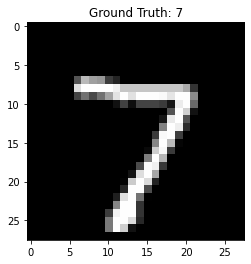

In [34]:
i = 0
plt.imshow(one_batch_of_test_subset_x[i][0], cmap='gray', interpolation='none')
_ = plt.title("Ground Truth: {}".format(one_batch_of_test_subset_y[i]))

In [5]:
class CNN_A(nn.Module):
    def __init__(self):
        super(CNN_A, self).__init__()
        # We can define the arguments of each layer in the __init__ method.
        # __init__ method will be called everytime we create an object of this class.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # This is the forward pass function.
        # See how we can save the activation outputs of each layer into a variable.
        # In this case, we are saving the output of each layer
        # to the same variable and replacing the value every time
        # before sending to a new layers.
        x = self.conv1(x)
        x = Functional.max_pool2d(x, 2)
        x = Functional.relu(x)
        
        x = self.conv2(x)
        x = Functional.max_pool2d(x, 2)
        x = Functional.relu(x)
        
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = Functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = Functional.relu(x) ## UPDATE ::
        return x

In [35]:
model = torch.load('cnn_a_model.pt')

In [36]:
model.to('cpu')

CNN_A(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [37]:
# Extract the output logit
output_logits = model(one_batch_of_test_subset_x[i].reshape(1,1,28,28)) # remember you need a 4D tensor of NCHW format.
print(output_logits)

tensor([[ 0.0000,  0.0000, 11.9198, 11.9203,  0.0000,  0.0000,  0.0000, 33.1333,
          0.0000,  7.4134]], grad_fn=<ReluBackward0>)


In [38]:
# Extract Probability vector
smax = torch.nn.Softmax(dim=1)
softmax_out = smax(torch.nn.functional.relu(output_logits))
print(softmax_out)

tensor([[4.0774e-15, 4.0774e-15, 6.1249e-10, 6.1280e-10, 4.0774e-15, 4.0774e-15,
         4.0774e-15, 1.0000e+00, 4.0774e-15, 6.7602e-12]],
       grad_fn=<SoftmaxBackward>)


In [39]:
# Find the max probability location
max_predictions = softmax_out.max(1, keepdim=True)
print(max_predictions)

torch.return_types.max(
values=tensor([[1.]], grad_fn=<MaxBackward0>),
indices=tensor([[7]]))


In [40]:
# Find the label with max probability
max_predicted_label = max_predictions.indices.item()
print(max_predicted_label)

7
